In [2]:
import torch
import torch.nn as nn
from torch.nn import init

def single_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv

def double_conv1(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(3,2),padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=(3,2),stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv

def double_conv2(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(3,3),padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=(3,3), padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv


def up_conv1(in_c, out_c):
    conv = nn.Sequential(
        nn.ConvTranspose2d(in_c, out_c, kernel_size=(2, 3), stride=2))
    return conv
    
def up_conv2(in_c, out_c):
    conv = nn.Sequential(
        nn.ConvTranspose2d(in_c, out_c, kernel_size=(2,2), stride=2))
    return conv


class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1

class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1


class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi



class Att_R2U(nn.Module):
    def __init__(self,img_ch=3,output_ch=3,t=2):
        super(Att_R2U, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.RCNN1 = RRCNN_block(img_ch, 64, t=t)
        self.RCNN2 = RRCNN_block(64, 128, t=t)
        self.RCNN3 = RRCNN_block(128, 256, t=t)

        self.up_trans_1 = up_conv1(256, 128)
        self.Att1 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_RRCNN1 = RRCNN_block(256, 128,t=t)
        
        self.up_trans_2 = up_conv2(128, 64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_RRCNN2 = RRCNN_block(128, 64,t=t)
        self.dropout = nn.Dropout(p=0.3)
        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=output_ch,
            kernel_size=1,stride=1,padding=0)

    def forward(self, image):
        # encoder
        # print("Input Image            => ", image.size())
        # print("Encoder =================")
        x1 = self.RCNN1(image)
        # print("Conv3x2, S1, P1        => ", x1.size())
        x2 = self.max_pool_2x2(x1)
        # print("max_pool_2x1           => ", x2.size())
        x3 = self.RCNN2(x2)
        x3 = self.dropout(x3)
        # print("Conv3x3, S1, P1        => ", x3.size())
        x4 = self.max_pool_2x2(x3)
        # print("max_pool_2x1           => ", x4.size())
        x5 = self.RCNN3(x4)
        x5 = self.dropout(x5)
        # print("Conv3x3, S1, P1        => ", x5.size())
        
        
        # decoder
        # print("Decoder =================")
        x = self.up_trans_1(x5)
        # print("up_trans_1x18, S3, P0  => ", x.size())
        x3 = nn.functional.interpolate(x3, (x.size()[2], x.size()[3]))
        x3 = self.Att1(g=x,x=x3)
        x = self.Up_RRCNN1(torch.cat([x, x3], 1))
        x = self.dropout(x)
        # print("up_conv_3x3, S1, P1    => ", x.size())

        x = self.up_trans_2(x)
        # print("up_trans_2x2, S2, P0   => ", x.size())
        x1 = nn.functional.interpolate(x1, (x.size()[2], x.size()[3]))
        x1 = self.Att2(g=x,x=x1)
        x = self.Up_RRCNN2(torch.cat([x, x1], 1))
        x = self.dropout(x)
        # print("up_conv_2x3, s1, p1    => ", x.size())
        # output
        x = self.out(x)
#         print(x.size())
        return x



if __name__ == "__main__":
#     print("start")
    image = torch.rand(1, 3, 8, 10)
    model = Att_R2U()
    print(model(image).size())

torch.Size([1, 3, 8, 10])


In [3]:
import scipy.io as sio
import numpy as np
import torch
import os
from os import listdir
from os.path import isfile, join
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np 
import math
import pandas as pd
import cmath
import scipy.io as sio
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import math
import pandas as pd
import cmath

#from unet import UNet
# from auto import encoder, decoder

from collections import OrderedDict
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
#==========================================================================
# For Plotting loss graph
# Bokeh
from bokeh.io import curdoc
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

from functools import partial
from threading import Thread
from tornado import gen
# from AttRCNN_UNet import Att_R2U
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
import sys
# from dataloader import norm
import csv
from sklearn.model_selection import train_test_split
from sys import getsizeof
# import wandb
# import logging
# logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

In [4]:
train_dataset_list = []
test_dataset_list = []

In [5]:
df1  = sio.loadmat("../SNS_dataset/400/DOA3/SNR_SNS_00_3_400.mat")

In [6]:
df1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'DOA', 'SNR_label', 'SNS_data', 'accuracy_sns', 'err_sns'])

In [7]:
df1['accuracy_sns']

array([[0.09799]])

In [8]:
df1  = sio.loadmat("../SNS_dataset/100/DOA4/SNR_SNS_00_4.mat")
df2  = sio.loadmat("../SNS_dataset/100/DOA4/SNR_SNS_10_4.mat")
df3  = sio.loadmat("../SNS_dataset/100/DOA4/SNR_SNS_20_4.mat")
df4  = sio.loadmat("../SNS_dataset/100/DOA4/SNR_SNS_30_4.mat")
df5  = sio.loadmat("../SNS_dataset/100/DOA4/SNR_SNS_40_4.mat")

In [9]:
df1['SNS_data'].shape

(8, 10, 100000)

In [10]:
def norm(df):
    # print(df["DOA"].shape)
    # print(df['NS_data'].shape)
    transp = np.transpose(df['SNS_data'], (2, 0, 1))
    new = np.zeros((100000, 3, 8, 10))
    for i in range(0, transp.shape[0]):
        for j in range(0, transp.shape[1]):
            for k in range(0, transp.shape[2]):
                new[i][0][j][k] = transp[i][j][k].real
                new[i][1][j][k] = transp[i][j][k].imag
                new[i][2][j][k] = cmath.phase(transp[i][j][k])

    max_r =  -10000000000000
    min_r = 10000000000000
    max_i =  -10000000000000
    min_i = 10000000000000
    max_p =  -10000000000000
    min_p = 10000000000000

    for i in range(0, new.shape[0]):
        for j in range(0, new.shape[1]):
            for k in range(0, new.shape[2]):
                if new[i][0][j][k] > max_r :
                    max_r = new[i][0][j][k]
                if new[i][0][j][k] < min_r:
                    min_r = new[i][0][j][k]
                if new[i][1][j][k] > max_i :
                    max_i = new[i][1][j][k]
                if new[i][1][j][k] < min_i:
                    min_i = new[i][1][j][k]
                if new[i][2][j][k] > max_p :
                    max_p = new[i][2][j][k]
                if new[i][2][j][k] < min_p:
                    min_p = new[i][2][j][k]
    print("St")
    print(max_r, max_i, max_p, min_r, min_i, min_p)

    ll = []
    ll.append(max_r)
    ll.append(max_i)
    ll.append(max_p)
    ll.append(min_r)
    ll.append(min_i)
    ll.append(min_p)
    return ll

# import glob

# files = glob.glob("../SNS_dataset/DOA3/*.mat")
# for i in files:
#     norm(i)

In [11]:
df = [df1, df2, df3, df4, df5]

In [12]:
norm_list = [norm(i) for i in df]

St
2.0127047828948776 2.045552062608406 3.141586435905599 -1.8110469693044937 -1.755851519284219 -3.141590575962246
St
1.4372812259740477 1.3972742207022322 3.1415917612098108 -1.3055565705732592 -1.5644204774975725 -3.1415915006569275
St
1.4280639175130034 1.2152126579974867 3.141592308830876 -1.3717195836763387 -1.3308847752497681 -3.141592413658264
St
1.4711718668788916 1.3229705661341953 3.141591746158677 -1.3430478930638148 -1.2021011090986107 -3.141591243785184
St
1.330725729082957 1.4261281253268836 3.141590132675938 -1.176012626277012 -1.294679573158777 -3.1415910727491974


In [13]:
(df1["SNS_data"].shape)

(8, 10, 100000)

In [14]:
new_train_dataset_list = []
new_test_dataset_list = []
train_dataset_list_label = []
test_dataset_list_label = []

In [15]:
def create_dataset(df):
    data = np.transpose(df['SNS_data'], (2, 0, 1))
    label = df['DOA']
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.05, random_state=42)
    new_train_dataset_list.extend(X_train)
    new_test_dataset_list.append(X_test.tolist())
    train_dataset_list_label.extend(y_train)
    test_dataset_list_label.append(y_test.tolist())

In [16]:
for file in df:
    create_dataset(file)

In [17]:
del df
del df1
del df2
del df3
del df4
del df5

In [18]:
len(new_train_dataset_list)

475000

In [19]:
max(norm_list[0][0], norm_list[1][0], norm_list[2][0], norm_list[3][0], norm_list[4][0])

2.0127047828948776

In [20]:
for idx, data in enumerate(new_train_dataset_list):
    max_r = max(norm_list[0][0], norm_list[1][0], norm_list[2][0], norm_list[3][0], norm_list[4][0])
    max_i = max(norm_list[0][1], norm_list[1][1], norm_list[2][1], norm_list[3][1], norm_list[4][1])
    max_p = max(norm_list[0][2], norm_list[1][2], norm_list[2][2], norm_list[3][2], norm_list[4][2])
    min_r = min(norm_list[0][3], norm_list[1][3], norm_list[2][3], norm_list[3][3], norm_list[4][3])
    min_i = min(norm_list[0][4], norm_list[1][4], norm_list[2][4], norm_list[3][4], norm_list[4][4])
    min_p = min(norm_list[0][5], norm_list[1][5], norm_list[2][5], norm_list[3][5], norm_list[4][5])
#     print(type((data[0][0])))
    new = np.zeros((3, 8, 10))
#     print(type(new[0][0][0]))
    for j in range(0, data.shape[0]):
        for k in range(0, data.shape[1]):
            new[0][j][k] =  (data[j][k].real  - min_r)/(max_r-min_r)
            new[1][j][k] =  (data[j][k].imag - min_i)/(max_i-min_i)
            new[2][j][k] = (cmath.phase(data[j][k]) - min_p)/ (max_p - min_p)
    new_train_dataset_list[idx] = new

In [21]:
for idx, data in enumerate(new_test_dataset_list):
    for i, ndata in enumerate(data):
        max_r = max(norm_list[0][0], norm_list[1][0], norm_list[2][0], norm_list[3][0], norm_list[4][0])
        max_i = max(norm_list[0][1], norm_list[1][1], norm_list[2][1], norm_list[3][1], norm_list[4][1])
        max_p = max(norm_list[0][2], norm_list[1][2], norm_list[2][2], norm_list[3][2], norm_list[4][2])
        min_r = min(norm_list[0][3], norm_list[1][3], norm_list[2][3], norm_list[3][3], norm_list[4][3])
        min_i = min(norm_list[0][4], norm_list[1][4], norm_list[2][4], norm_list[3][4], norm_list[4][4])
        min_p = min(norm_list[0][5], norm_list[1][5], norm_list[2][5], norm_list[3][5], norm_list[4][5])
        new = np.zeros((3, 8, 10))
        for j in range(0, 8):
            for k in range(0, 10):
                new[0][j][k] =  (ndata[j][k].real  - min_r)/(max_r-min_r)
                new[1][j][k] =  (ndata[j][k].imag - min_i)/(max_i-min_i)
                new[2][j][k] = (cmath.phase(ndata[j][k]) - min_p)/ (max_p - min_p)
        new_test_dataset_list[idx][i] = new

In [22]:
def get_data(train, test, batch_size, train_bool=True):
    class DOA_dataset(Dataset):
        def __init__(self, train, test):
            self.x = torch.from_numpy(np.array(train))
            self.y = torch.from_numpy(np.asarray(test))
            self.n_sample = len(self.y)
        def __getitem__(self, index):
            return self.x[index], self.y[index]
        def __len__(self):
            return self.n_sample


    dataset = DOA_dataset(train, test)
    

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train_bool)
    return loader


In [23]:
doa2_train_loader = get_data(new_train_dataset_list, train_dataset_list_label, 64, True)

In [24]:
del new_train_dataset_list
del train_dataset_list_label

In [25]:
test_dataset_list = []

In [26]:
for idx, data in enumerate(new_test_dataset_list):
    print(type(data))
    f = get_data(data, test_dataset_list_label[idx], 128, False)
    test_dataset_list.append(f)

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [27]:
del new_test_dataset_list
del new

In [28]:
# from pytorch_metric_learning import losses, miners, distances, reducers, testers
# from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
# distance = distances.CosineSimilarity()
# reducer = reducers.ThresholdReducer(low = 0)
# loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
# mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")

In [29]:
# def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
#     model.train()
#     for batch_idx, (data, labels) in enumerate(train_loader):
#         data, labels = Variable(data.cuda()), Variable(labels.cuda())
#         optimizer.zero_grad()
# #         image = torch.rand(1, 3, 8, 100)
#         embeddings = model(data.float())
# #         embeddings = embeddings.reshape(embeddings.size(0), 181)
# #         labels = torch.zeros([64, 1]).cuda()
#         print(embeddings.size(), data.size())
#         indices_tuple = mining_func(embeddings,data.float())
#         loss = loss_func(embeddings, labels, indices_tuple)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 1400 == 0:
#             print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))

In [30]:

# ### convenient function from pytorch-metric-learning ###
# def get_all_embeddings(dataset, model):
#     tester = testers.BaseTester()
#     return tester.get_all_embeddings(dataset, model)

# # def test(testloader, model):
# #     model.eval()
# #     validation_loss = 0
# #     correct = 0
# #     total = 0
# #     with torch.no_grad():
# #         for features, labels in testloader:
# #             features, labels = Variable(features.cuda()), Variable(labels.cuda())
# #             enn = autoencoder(features.float())
# #             auto_outputs = torch.transpose(enn, 2, 3)
# #             auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 1))
# #             loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

# #             _, pred = torch.max(auto_outputs, 1)
# #             total+= labels.reshape(-1).size(0)
# #             correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
# #             validation_loss += loss.item()
# # #             wandb.log({"Validation Acc "+str(val_data):(100*(correct/total)),"Validation Loss "+str(val_data):( validation_loss/len(test_dataset_list[val_data]))})
# #     print(val_data*10, "dB SNR is validated")
# # #     vl1[val_data].append((100*(correct/total)))
# #     print("Validationloss: {}".format( validation_loss/len(test_dataset_list[val_data])), " ---- Validation Acc: {}".format(100*(correct/total)))
# # print("\n")  
    

In [31]:
    
# device = torch.device("cuda")
# autoencoder = Att_R2U()
# model = autoencoder.cuda()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# ### pytorch-metric-learning stuff ###
# distance = distances.CosineSimilarity()
# reducer = reducers.ThresholdReducer(low = 0)
# loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer) #losses.NTXentLoss(temperature=0.07) 
# mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")
# accuracy_calculator = AccuracyCalculator(include = ("precision_at_1",), k = 1)


In [32]:
# for epoch in range(0, 100):
# #     for data in range(0, len(train_dataset_list)):
# #         print("Training has started for ", str(data*10), "dB SNR" )
#     train(model, loss_func, mining_func, device, doa2_train_loader, optimizer, epoch+1)
# #     for val_data in range(0, len(test_dataset_list)):
# #         print("Validation has started for ", str(val_data*10), "dB SNR" )
# #         test(train_dataset_list[val_data], test_dataset_list[val_data], model, accuracy_calculator)

In [33]:
import torch.nn.functional as F

In [34]:
for j,(features, labels) in enumerate(doa2_train_loader, 0):
    features, labels = Variable(features), Variable(labels)
    out = model(features.float())
    print("out", out.size())
    print("features", features.size())
    out = F.sigmoid(out)
    loss = criterion(out, features.float())
    print(loss)
    break

out torch.Size([64, 3, 8, 10])
features torch.Size([64, 3, 8, 10])


/home/iiitd/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


NameError: name 'criterion' is not defined

In [ ]:

image = torch.rand(64, 3, 8, 10)
model = Att_R2U()
print(model(image).size())

In [42]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [ ]:
!pip install -q pytorch-metric-learning[with-hooks]

In [ ]:
from pytorch_metric_learning import losses, miners

In [ ]:
loss_fn = losses.CrossBatchMemory(loss = losses.NTXentLoss(temperature = 0.1),
                                  embedding_size = 128,
                                  memory_size = memory_size)

In [48]:
autoencoder = Att_R2U()

num_epochs = 50
doa = 100
weights_dir = "./doa_weights/"

# autoencoder = ResNet18()
criterion = nn.BCELoss()
focal_criterion = FocalLoss()
# if ('SNS_DOA_{}_model.pth'.format(doa) in [f for f in listdir(weights_dir) if isfile(join(weights_dir, f))]):
#     print("Pre-trained available for DOA_{}_model.pth".format(doa))
#     autoencoder = torch.load(os.path.join(weights_dir, 'SNS_DOA_{}_model.pth'.format(doa)))

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
	classification_model = autoencoder.cuda()
	optimizer = optim.AdamW(classification_model.parameters(), lr=0.01, weight_decay=1e-6)
	criterion = criterion.cuda()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", factor=0.05, patience=5, verbose=True)

GeForce GTX 1080 Ti


In [49]:
acc_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
loss_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
mae_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}

In [50]:
def train():
    print("Training Starts !!!!!!!")
    best_valid_loss = float('Inf')
    for i in range(num_epochs):
        training_loss = 0
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0
        training_mae = 0.0
        classification_model.train()
        for j,(features, labels) in enumerate(doa2_train_loader, 0):
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            enn = classification_model(features.float())
            enn = F.sigmoid(enn)
#             print("enn", enn.size())
#             print("features", features.size())
            losss = criterion(enn.cuda(), features.float())
            losss.backward()
            optimizer.step()
            training_loss += losss.item()

            epoch_loss += enn.shape[0] * losss.item()

        loss_res['training'].append(training_loss/len(doa2_train_loader))
        print('Epoch [{}/{}], Training Loss: {:.4f}'
                      .format(i+1, num_epochs, training_loss/len(doa2_train_loader)))
        
        # Validation for each SNR value
        classification_model.eval()
        total_valdation_loss = 0
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_acc = 0
            validation_mae = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    enn = F.sigmoid(enn)
#                     auto_outputs = torch.transpose(enn, 2, 3)
#                     auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 3))
                    loss = criterion(enn.cuda(), features.float())

#                     _, pred = torch.max(enn, 1)
#                     val_total+= labels.reshape(-1).size(0)
#                     val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
#                     validation_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()

                loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
                
                print('SNR [{}dB], Validation Loss: {:.4f}'
                      .format(val_data*10, validation_loss/len(test_dataset_list[val_data])))

                total_valdation_loss+=validation_loss
        scheduler.step(loss_res["training"][len(loss_res["training"])-1])
        torch.save( classification_model, weights_dir+ "/SNS_DOA_{}_Unet_model.pth".format(doa))
        if best_valid_loss > total_valdation_loss:
            best_valid_loss = total_valdation_loss 
            # Saving Best Pre-Trained Model as .pth file
            torch.save( classification_model, weights_dir+ "/DOA_{}_best_Unet_model.pth".format(doa))
#         if i%10 == 0:
#           ddf = pd.DataFrame(acc_res)
#           ddf.to_csv(weights_dir+"res_DOA_{}_model.csv".format(doa))
        print("\n")  

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch [1/50], Training Loss: 19.5881
SNR [0dB], Validation Loss: 52.1565
SNR [10dB], Validation Loss: 52.1571
SNR [20dB], Validation Loss: 52.1093
SNR [30dB], Validation Loss: 52.1469
SNR [40dB], Validation Loss: 52.1230


Epoch [2/50], Training Loss: 52.1450
SNR [0dB], Validation Loss: 52.1565
SNR [10dB], Validation Loss: 52.1571
SNR [20dB], Validation Loss: 52.1093
SNR [30dB], Validation Loss: 52.1469
SNR [40dB], Validation Loss: 52.1230


Epoch [3/50], Training Loss: 51.3436
SNR [0dB], Validation Loss: 51.3163
SNR [10dB], Validation Loss: 51.2768
SNR [20dB], Validation Loss: 51.2706
SNR [30dB], Validation Loss: 51.2954
SNR [40dB], Validation Loss: 51.2524


Epoch [4/50], Training Loss: 50.4183
SNR [0dB], Validation Loss: 50.0018
SNR [10dB], Validation Loss: 49.9844
SNR [20dB], Validation Loss: 50.0155
SNR [30dB], Validation Loss: 49.9841
SNR [40dB], Validation Loss: 49.9926


Epoch [5/50], Training Loss: 50.0921
SNR [0dB], Validation Loss: 50.1923
SNR [10dB],

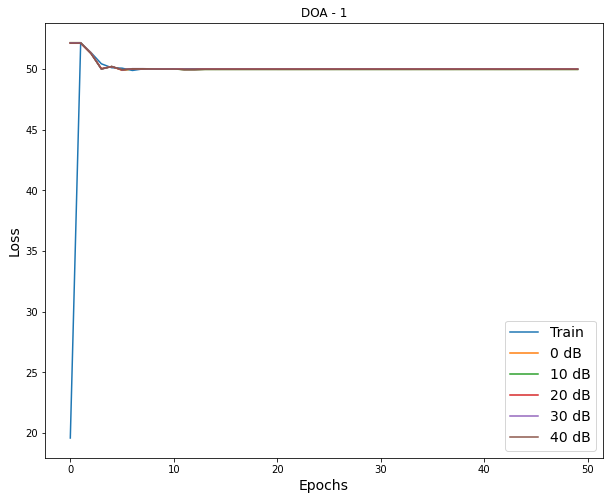

In [51]:
import matplotlib.pyplot as plt
ep = range(0, len(loss_res["training"]))
plt.figure(figsize=(10, 8))
plt.plot(ep, loss_res["training"], label='Train')
plt.plot(ep, loss_res[0], label='0 dB')
plt.plot(ep, loss_res[10], label='10 dB')
plt.plot(ep, loss_res[20], label='20 dB')
plt.plot(ep, loss_res[30], label='30 dB')
plt.plot(ep, loss_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("DOA - {}".format(doa))
plt.legend(fontsize=14)
plt.show()